In [ ]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset


In [ ]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
images = torch.load('generated_images1.pth')
labels = torch.load('generated_labels1.pth')
# print(labels[8][1])

for i in range(4):
    fig = plt.figure(figsize=(17,17))
    for bid in range(25):
        ax1 = fig.add_subplot(1, 25, bid+1)
        img1= images[1][bid+25*i]
        ax1.imshow(torchvision.utils.make_grid(img1))
        ax1.set_title(labels[1][bid+25*i])
        ax1.axis("off")
    

Client 0 | batch 0 | total imgs 0


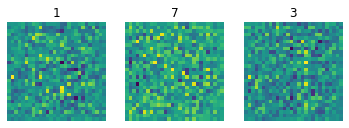

Client 0 | batch 1 | total imgs 3


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.45 GiB already allocated; 0 bytes free; 3.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from aijack.attack import GradientInversion_Attack

class LeNet(nn.Module):
    def __init__(self, channel=1, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channel, 32, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(6272, num_classes)
            # nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

batch_size = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in torch.load('../data/MNIST.pth')]

generated_images = []
generated_labels = []

for i in range(2):
    client_img = []
    client_label = []
    dataiter = iter(train_loader[i])

    # for batch_idx in range(len(train_loader[i])):
    for batch_idx in range(3):
        print("Client "+ str(i) +" | batch "+str(batch_idx) + " | total imgs " + str(len(client_img)))
        images, labels = dataiter.next()
        images = images.cuda()
        labels = labels.cuda()

        criterion = nn.CrossEntropyLoss()
        # net = LeNet(channel=3, hideen=768, num_classes=10)
        net = LeNet(channel=1, num_classes=10)
        net.to(device)
        pred = net(images[:batch_size])
        loss = criterion(pred, labels[:batch_size])
        received_gradients = torch.autograd.grad(loss, net.parameters())
        received_gradients = [cg.detach() for cg in received_gradients]

        gradinversion = GradientInversion_Attack(net, (1, 28, 28), num_iteration=500,
                                            lr=1e2, log_interval=0,
                                            optimizer_class=torch.optim.SGD,
                                            distancename="l2", optimize_label=False,
                                            bn_reg_layers=[net.body[4], net.body[8]],
                                            group_num = 3,
                                            tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                            bn_reg_coef=0.001, gc_reg_coef=0.001, device=device)

        result = gradinversion.group_attack(received_gradients, batch_size=batch_size)
        
        fig = plt.figure()
        for bid in range(batch_size):
            test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
            img1 = test_img.swapaxes(0,1)
            img1 = img1.swapaxes(1,2)
            ax1 = fig.add_subplot(2, batch_size, bid+1)
            test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
            img1 = test_img.swapaxes(0,1)
            img1 = img1.swapaxes(1,2)
            ax1.imshow(torchvision.utils.make_grid(img1))
            ax1.set_title(result[1][0][bid].item())
            ax1.axis("off")
            
            client_img.append(img1)
            label = result[1][0][bid].item()
            client_label.append(label)
        plt.show()
    generated_images.append(client_img)
    generated_labels.append(client_label)
torch.save(generated_images, 'generated_images2.pth')
torch.save(generated_labels, 'generated_labels2.pth')

In [ ]:
def draw_out(attacker, received_gradients, batch_size=0):
    num_seeds=3
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    for s in tqdm(range(num_seeds)):
        attacker.reset_seed(s)
        if batch_size > 0:
            result = attacker.attack(received_gradients, batch_size=batch_size)
        else:
            result = attacker.attack(received_gradients)
        ax1 = fig.add_subplot(3, num_seeds, s+1)
        test_img = torch.from_numpy((result[0].cpu().detach().numpy()[0])) / 2 + 0.5
        img1 = test_img.swapaxes(0,1)
        img1 = img1.swapaxes(1,2)
        ax1.imshow(torchvision.utils.make_grid(img1))
        ax1.set_title(torch.argmax(result[1]).item())
        ax1.axis("off")
        ax2 = fig.add_subplot(3, num_seeds, num_seeds+s+1)
        ax2.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
        ax2.axis("off")
        ax3 = fig.add_subplot(3, num_seeds, num_seeds + num_seeds+s+1)
        ax3.imshow(cv2.medianBlur(result[0].cpu().detach().numpy()[0][0], 5), cmap="gray")
        ax3.axis("off")
    plt.suptitle("Result")
    plt.tight_layout()
    plt.show()


## DLG Attack
https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize both of images and labels

In [ ]:
imshow(torchvision.utils.make_grid(images[0].cpu()))
print("Target")
criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

dlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
                                    num_iteration=1000,
                                    distancename="l2", device=device)

draw_out(dlg_attacker, received_gradients)

In [ ]:
draw_out(dlg_attacker, received_gradients)

## GS Attack
https://arxiv.org/abs/2003.14053
- distance metric = cosine similarity
- optimize both of images and labels
- total-variance regularization

In [ ]:
# imshow(torchvision.utils.make_grid(images[0].cpu()))

# criterion = nn.CrossEntropyLoss()
# net = LeNet(channel=3, hideen=768, num_classes=10)
# net.to(device)
# pred = net(images[:1])
# loss = criterion(pred, labels[:1])
# received_gradients = torch.autograd.grad(loss, net.parameters())
# received_gradients = [cg.detach() for cg in received_gradients]

# gs_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
#                                     num_iteration=200,
#                                     tv_reg_coef=0.01,
#                                     distancename="cossim", device=device)

# draw_out(gs_attacker, received_gradients)

## IDLG Attack
https://arxiv.org/abs/2001.02610
- distance metric = L2 norm
- optimize only an image & estimate a label from the gradients

In [ ]:
imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

idlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000, device=device)

draw_out(idlg_attacker, received_gradients)

## CPL Attack
https://arxiv.org/abs/2004.10397
- distance metric = L2 norm
- optimize only images & estimate an label from the gradients
- label-matching regularization

In [ ]:
import torch.optim as optim

imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1)
# for epoch in range(10):
pred = net(images[:1])
loss = criterion(pred, labels[:1])
loss.backward(retain_graph=True)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach()for cg in received_gradients]

cpl_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000,
                                    lm_reg_coef=0.01, device=device)

draw_out(cpl_attacker, received_gradients)

    # optimizer.step()


## Test Atk

In [ ]:
# import torch.optim as optim

# imshow(torchvision.utils.make_grid(images[0:3].cpu()))

# criterion = nn.CrossEntropyLoss()
# net = LeNet(channel=3, hideen=768, num_classes=10)
# net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1)
# for epoch in range(3):
#     pred = net(images[:1])

#     loss = criterion(pred, labels[:1])
#     loss.backward(retain_graph=True)

#     received_gradients = torch.autograd.grad(loss, net.parameters())
#     received_gradients = [cg.detach()/(-0.1)  for cg in received_gradients]
    
#     optimizer.step()
    
# cpl_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
#                                     optimizer_class=torch.optim.SGD,
#                                     distancename="l2", optimize_label=False,
#                                     num_iteration=10000,
#                                     lm_reg_coef=0.01, device=device)

# draw_out(cpl_attacker, received_gradients, batch_size=3)
    
# gradinversion = GradientInversion_Attack(net, (3, 32, 32), num_iteration=1900,
#                                         lr=1e2, log_interval=0,
#                                         optimizer_class=torch.optim.SGD,
#                                         distancename="l2", optimize_label=False,
#                                         bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
#                                         group_num = 3,
#                                         tv_reg_coef=0.00, l2_reg_coef=0.0001,
#                                         bn_reg_coef=0.001, gc_reg_coef=0.001, device=device)

# result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

# fig = plt.figure()
# for bid in range(batch_size):
#     ax1 = fig.add_subplot(2, batch_size, bid+1)
#     test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
#     img1 = test_img.swapaxes(0,1)
#     img1 = img1.swapaxes(1,2)
#     ax1.imshow(torchvision.utils.make_grid(img1))
#     ax1.set_title(result[1][0][bid].item())
#     ax1.axis("off")
#     ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
#     ax2.imshow((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid][0], cmap="gray")
#     ax2.axis("off")

## GradInversion
https://arxiv.org/abs/2104.07586
- distance metric = L2 norm
- optimize only images & estimate labels from the gradients
- total-variance, l2, bn, and group-consistency regularization

In [ ]:
batch_size = 8

train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in torch.load('../data/cifar10.pth')]
for i in range(len(train_loader)):
    dataiter = iter(train_loader[i])
    images, labels = dataiter.next()
    images = images.cuda()
    labels = labels.cuda()

    imshow(torchvision.utils.make_grid(images.cpu()))

    criterion = nn.CrossEntropyLoss()
    net = LeNet(channel=3, hideen=768, num_classes=10)
    net.to(device)
    pred = net(images[:batch_size])
    loss = criterion(pred, labels[:batch_size])
    received_gradients = torch.autograd.grad(loss, net.parameters())
    received_gradients = [cg.detach() for cg in received_gradients]

    gradinversion = GradientInversion_Attack(net, (3, 32, 32), num_iteration=900,
                                        lr=1e2, log_interval=0,
                                        optimizer_class=torch.optim.SGD,
                                        distancename="l2", optimize_label=False,
                                        bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                        group_num = 3,
                                        tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                        bn_reg_coef=0.001, gc_reg_coef=0.001, device=device)

    result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

    fig = plt.figure()
    for bid in range(batch_size):
        ax1 = fig.add_subplot(2, batch_size, bid+1)
        test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
        img1 = test_img.swapaxes(0,1)
        img1 = img1.swapaxes(1,2)
        ax1.imshow(torchvision.utils.make_grid(img1))
        ax1.set_title(result[1][0][bid].item())
        ax1.axis("off")
        # ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
        # ax2.imshow((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid][0], cmap="gray")
        # ax2.axis("off")

    plt.suptitle("Result of GradInversion")